Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

('Found and verified', 'notMNIST_large.tar.gz')
('Found and verified', 'notMNIST_small.tar.gz')


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10

def extract(filename):
  tar = tarfile.open(filename)
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  print('Extracting data for %s. This may take a while. Please wait.' % root)
  sys.stdout.flush()
  tar.extractall()
  tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root)) if d != '.DS_Store']
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = extract(train_filename)
test_folders = extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [5]:
path = 'notMNIST_small/C/'
dirs = os.listdir( path )
for file in dirs[:10]:
   display(Image(filename='notMNIST_small/C/'+file))




---
Problem 1
---------

Let's take a peek at some of 
the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

In [2]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

train_folders = ['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']

test_folders = ['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print(folder)
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          image_index, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  print('Labels:', labels.shape)
  return dataset, labels
train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)

notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
notMNIST_large/C
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
notMNIST_large/E
notMNIST_large/F
notMNIST_large/G
notMNIST_large/H


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [22]:
from PIL import Image
im = Image.open('retina_small.jpg')
im.save('retina_small.png')

In [24]:
%matplotlib inline
import matplotlib.image as mpimg
img=mpimg.imread('retina_small.png')
print img

[[[ 0.          0.          0.        ]
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.00392157  0.00392157  0.00392157]
  ..., 
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.00392157  0.00392157  0.00392157]]

 [[ 0.          0.          0.        ]
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.00392157  0.00392157  0.00392157]
  ..., 
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.00392157  0.00392157  0.00392157]]

 [[ 0.          0.          0.        ]
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.00392157  0.00392157  0.00392157]
  ..., 
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.00784314  0.00784314  0.00784314]
  [ 0.00392157  0.00392157  0.00392157]]

 ..., 
 [[ 0.00392157  0.00392157  0.00392157]
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.          0.          0.        ]
  ..., 
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.00392157  0.00392157  0.00392157]
  [ 0.00392157  0.00392157  0.00392

<type 'numpy.ndarray'> (200, 238, 3)
1.0 0.0


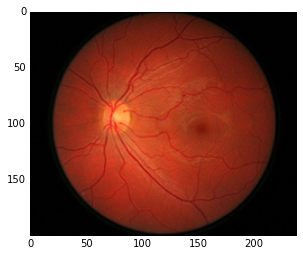

In [26]:
imgplot = plt.imshow(img) # the first dimension 200 is the height measured from top down, the second is the width
# from the left to right and the third is different colors
print type(img), img.shape
print np.max(img), np.min(img)

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [4]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [6]:
train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print('Training', train_dataset.shape, train_labels.shape)
print('Validation', valid_dataset.shape, valid_labels.shape)
print(valid_labels[3])
imgplot = plt.imshow(valid_dataset[3])

Training (200000, 28, 28) (200000,)
Validation (10000, 28, 28) (10000,)
7


Finally, let's save the data for later reuse:

In [7]:
pickle_file = 'notMNIST3.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [13]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 718193801)


1.5
(28, 28, 3)
(28, 28, 3)


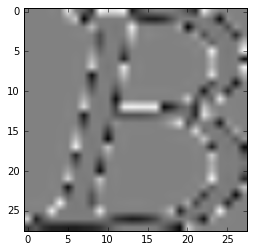

In [60]:
print np.max(train_dataset+1)
train_dataset1 =np.expand_dims(np.random.rand(*train_dataset[0].shape),axis=3)
train_dataset1 = np.dstack([train_dataset1 for i in range(3)])
print train_dataset1.shape
for i in xrange(3):
    train_dataset1[:,:,i]=train_dataset[0]
print train_dataset1.shape
imgplot = plt.imshow(train_dataset1)

(375, 500, 3)


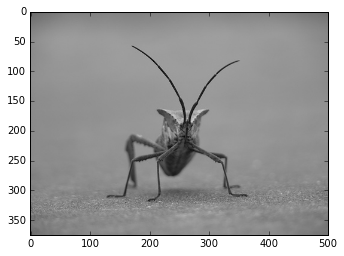

In [34]:
img=mpimg.imread('stinkbug.png')
imgplot = plt.imshow(img)
print img.shape
    

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [1]:
import pickle
notMNIST = pickle.load( open( "notMNIST.pickle", "rb" ) )
import os
import urllib

target_dir = "data"
target_path = os.path.join(target_dir, "cifar-10-python.tar.gz")

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

if not os.path.exists(target_path):
    print "Downloading..."
    urllib.urlretrieve("http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "data/cifar-10-python.tar.gz")

print "Extracting..."
os.system("tar xzvf data/cifar-10-python.tar.gz -C data")

print "done."

In [5]:
type(notMNIST)
len(notMNIST)
for key,val in notMNIST.items():
        exec(key + '=val')

In [13]:
import theano
import theano.tensor as T
import numpy as np
import load
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d


In [25]:
x_train, t_train, x_test, t_test = load.cifar10(dtype=theano.config.floatX)
print x_train.shape, t_train.shape, x_test.shape, t_test.shape
#x_train, t_train, x_test, t_test = train_dataset, train_labels, test_dataset, test_labels

(50000, 1024) (50000, 10) (10000, 1024) (10000, 10)


In [28]:
print train_dataset.shape, train_labels.shape
train_labels = load.one_hot(train_labels, n=10)
print train_dataset.shape, train_labels.shape
test_labels = load.one_hot(test_labels, n=10)
print test_labels.shape

(10000,)


In [30]:
#'train_dataset': train_dataset,
#'train_labels': train_labels,
#'valid_dataset': valid_dataset,
#'valid_labels': valid_labels,
#'test_dataset': test_dataset,
#'test_labels': test_labels,


(200000, 28, 28) (200000,)
(200000, 28, 28) (200000, 10)


(200000, 1, 28, 28) (200000, 10) (18724, 1, 28, 28) (18724, 10)


In [37]:
x_train, t_train, x_test, t_test = train_dataset, train_labels, test_dataset, test_labels
labels_test = np.argmax(t_test, axis=1)
print x_train.shape, t_train.shape, x_test.shape, t_test.shape, labels_test.shape
x_train = x_train.reshape((x_train.shape[0], 1, 28, 28))
x_test = x_test.reshape((x_test.shape[0], 1, 28, 28))

(18724,)


In [ ]:
# define symbolic Theano variables
x = T.tensor4()
t = T.matrix()

# define model: neural network
def floatX(x):
    return np.asarray(x, dtype=theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.1))

def momentum(cost, params, learning_rate, momentum):
    grads = theano.grad(cost, params)
    updates = []
    
    for p, g in zip(params, grads):
        mparam_i = theano.shared(np.zeros(p.get_value().shape, dtype=theano.config.floatX))
        v = momentum * mparam_i - learning_rate * g
        updates.append((mparam_i, v))
        updates.append((p, p + v))

    return updates

def model(x, w_c1, b_c1, w_c2, b_c2, w_h3, b_h3, w_o, b_o):
    # original was 32 -3 +1 = 30, pool by 3 to 10
    #new 28-3+1 =26 , pool by 2 to 13
    c1 = T.maximum(0, conv2d(x, w_c1) + b_c1.dimshuffle('x', 0, 'x', 'x'))
    p1 = max_pool_2d(c1, (2, 2))
    
    #10 -3 +1 = 8, pool by 2 to 4
    # new 13 -2 +1 = 12 , pool by 2 to 6
    c2 = T.maximum(0, conv2d(p1, w_c2) + b_c2.dimshuffle('x', 0, 'x', 'x'))
    p2 = max_pool_2d(c2, (2, 2))

    #flattenned number of neurons is now 8*4*4
    # new flattened bumber of neurons is 8*6*6
    p2_flat = p2.flatten(2)
    h3 = T.maximum(0, T.dot(p2_flat, w_h3) + b_h3)
    p_y_given_x = T.nnet.softmax(T.dot(h3, w_o) + b_o)
    return p_y_given_x

w_c1 = init_weights((4, 1, 3, 3))
b_c1 = init_weights((4,))
w_c2 = init_weights((8, 4, 3, 3))
b_c2 = init_weights((8,))
w_h3 = init_weights((8 * 6 * 6, 100))
b_h3 = init_weights((100,))
w_o = init_weights((100, 10))
b_o = init_weights((10,))

params = [w_c1, b_c1, w_c2, b_c2, w_h3, b_h3, w_o, b_o]

p_y_given_x = model(x, *params)
y = T.argmax(p_y_given_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(p_y_given_x, t))

updates = momentum(cost, params, learning_rate=0.01, momentum=0.9)


# compile theano functions
train = theano.function([x, t], cost, updates=updates)
predict = theano.function([x], y)


# train model
batch_size = 50

for i in range(5):
    print "iteration %d" % (i + 1)
    for start in range(0, len(x_train), batch_size):
        x_batch = x_train[start:start + batch_size]
        t_batch = t_train[start:start + batch_size]
        cost = train(x_batch, t_batch)

    predictions_test = predict(x_test)
    accuracy = np.mean(predictions_test == labels_test)
    print "accuracy: %.5f" % accuracy

In [40]:
predictions_test = predict(x_test)
accuracy = np.mean(predictions_test == labels_test)
print "accuracy: %.5f" % accuracy

accuracy: 0.93255


(28, 28)


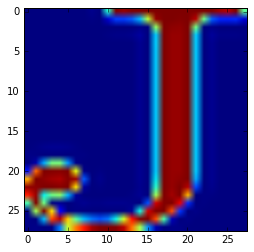

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
print x_test[1][0].shape
imgplot = plt.imshow(x_test[1][0])

In [74]:
import numpy as np
print labels_test[1]
predictions_valid = predict(np.expand_dims(x_test[1],axis=0))
print predictions_valid

9
[9]
